In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# 1. EDA

In [3]:
df= pd.read_csv('ToyotaCorolla - MLR.csv')
print(df.shape)
df.head()

(1436, 11)


,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
0,13500,23,46986,Diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,Diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,Diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,Diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,Diesel,90,0,2000,3,4,5,1170


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Age_08_04  1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   Fuel_Type  1436 non-null   object
 4   HP         1436 non-null   int64 
 5   Automatic  1436 non-null   int64 
 6   cc         1436 non-null   int64 
 7   Doors      1436 non-null   int64 
 8   Cylinders  1436 non-null   int64 
 9   Gears      1436 non-null   int64 
 10  Weight     1436 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 123.5+ KB


In [5]:
print(df.isnull().sum())
print(df.duplicated().sum())

Price        0
Age_08_04    0
KM           0
Fuel_Type    0
HP           0
Automatic    0
cc           0
Doors        0
Cylinders    0
Gears        0
Weight       0
dtype: int64
1


In [6]:
# 1. Dropping Duplicates
df.drop_duplicates(inplace=True, ignore_index=True)
df.duplicated().sum()

np.int64(0)

<Axes: >

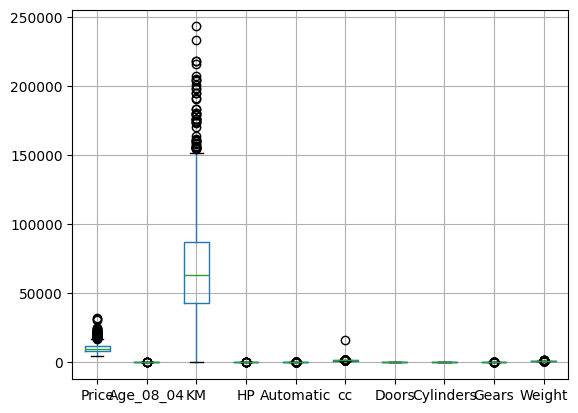

In [7]:
# 2. Detecting and removing Outliers
df.boxplot()

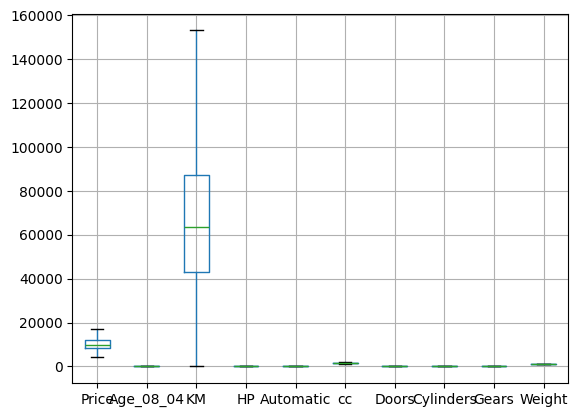

In [8]:
def replace_outliers(df):
    def replace(col):
        Q1 = df[col].quantile(0.25)        
        Q3 = df[col].quantile(0.75)     
        IQR = Q3 - Q1
        lower_extreme = Q1 - 1.5*IQR   
        upper_extreme = Q3 + 1.5*IQR   
        df[col] = df[col].apply(lambda x: lower_extreme if x < lower_extreme else upper_extreme if x > upper_extreme else x)

    for c in df.select_dtypes(include=["int", "float"]).columns:
        replace(c)

replace_outliers(df)
df.boxplot()
plt.show()

In [9]:
target = df["Price"]

In [10]:
# 3. Labelling
'''
One Hot Encoding labelling the Fuel_type data, ['Diesel', 'Petrol', 'CNG']
'''

# # One hot Encoding with pandas 
features=pd.get_dummies(df.drop(columns=["Price"]).copy(),dtype='int')
features


,Age_08_04,KM,HP,Automatic,cc,Doors,Cylinders,Gears,Weight,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol
0,23.0,46986.0,90.0,0.0,1900.0,3,4,5.0,1152.5,0,1,0
1,23.0,72937.0,90.0,0.0,1900.0,3,4,5.0,1152.5,0,1,0
2,24.0,41711.0,90.0,0.0,1900.0,3,4,5.0,1152.5,0,1,0
3,26.0,48000.0,90.0,0.0,1900.0,3,4,5.0,1152.5,0,1,0
4,30.0,38500.0,90.0,0.0,1900.0,3,4,5.0,1152.5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1430,69.0,20544.0,86.0,0.0,1300.0,3,4,5.0,1025.0,0,0,1
1431,72.0,19000.0,86.0,0.0,1300.0,3,4,5.0,1015.0,0,0,1
1432,71.0,17016.0,86.0,0.0,1300.0,3,4,5.0,1015.0,0,0,1
1433,70.0,16916.0,86.0,0.0,1300.0,3,4,5.0,1015.0,0,0,1


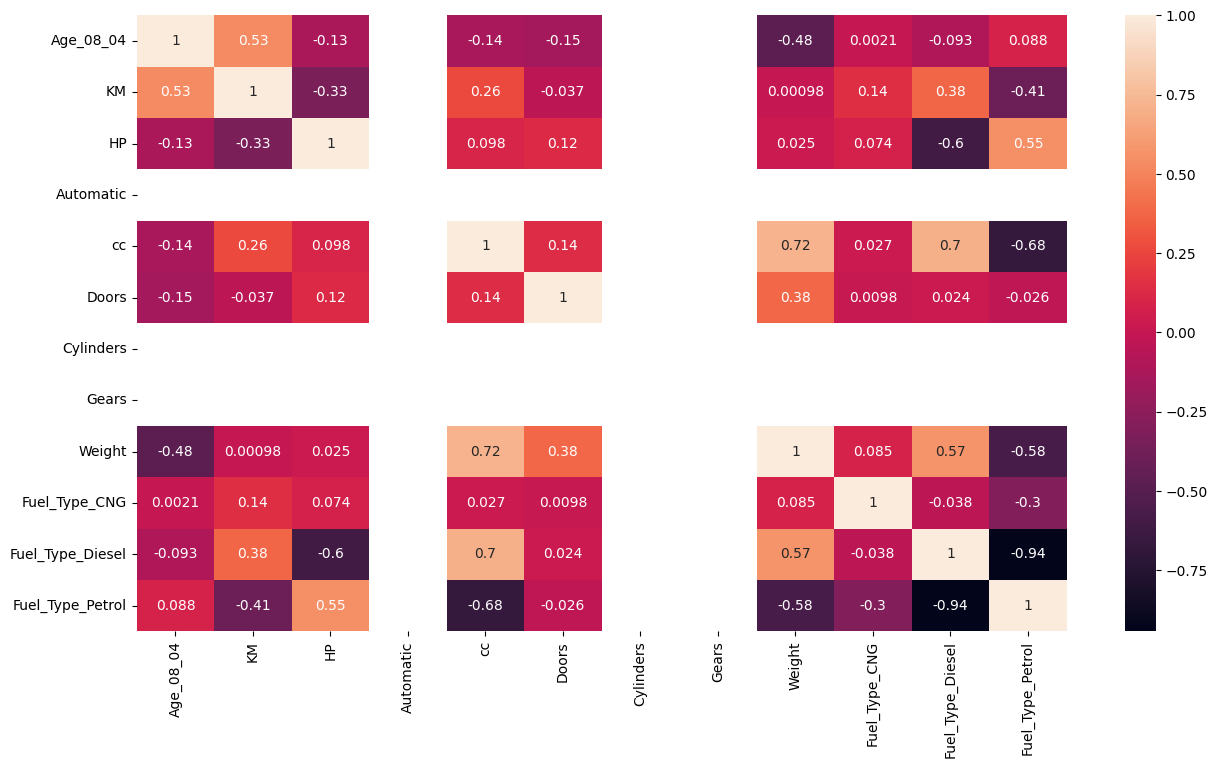

In [11]:
# 4. Observing multi-collinearity
corr = features.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr,annot=True)
plt.show()

In [12]:
'''
Columns having correlation more than 0.5 are;

1) Fuel_Type_Diesel - HP (-0.6)
2) Fuel_Type_Diesel - Weight (0.57)
3) Fuel_Type_Diesel - CC (0.7)
4) Fuel_Type_Petrol - CC (-0.68)
5) Fuel_Type_Petrol - HP (0.55)
6) Fuel_Type_Petrol - Weight (-0.58) 
7) Fuel_Type_Petrol - Fuel_Type_Diesel (-0.94)
8) Weight - CC (-0.72)
'''

'\nColumns having correlation more than 0.5 are;\n\n1) Fuel_Type_Diesel - HP (-0.6)\n2) Fuel_Type_Diesel - Weight (0.57)\n3) Fuel_Type_Diesel - CC (0.7)\n4) Fuel_Type_Petrol - CC (-0.68)\n5) Fuel_Type_Petrol - HP (0.55)\n6) Fuel_Type_Petrol - Weight (-0.58) \n7) Fuel_Type_Petrol - Fuel_Type_Diesel (-0.94)\n8) Weight - CC (-0.72)\n'

In [13]:
vif= pd.DataFrame()
vif['features']= features.columns
vif['VIF_Score']= [variance_inflation_factor(features.values,i) for i in range(len(features.columns))]
vif.sort_values(ascending=False,by= 'VIF_Score')

,features,VIF_Score
9,Fuel_Type_CNG,inf
11,Fuel_Type_Petrol,inf
10,Fuel_Type_Diesel,inf
4,cc,12.807789
2,HP,10.104386
8,Weight,3.853438
0,Age_08_04,2.181306
1,KM,2.015390
5,Doors,1.302842
7,Gears,0.000000


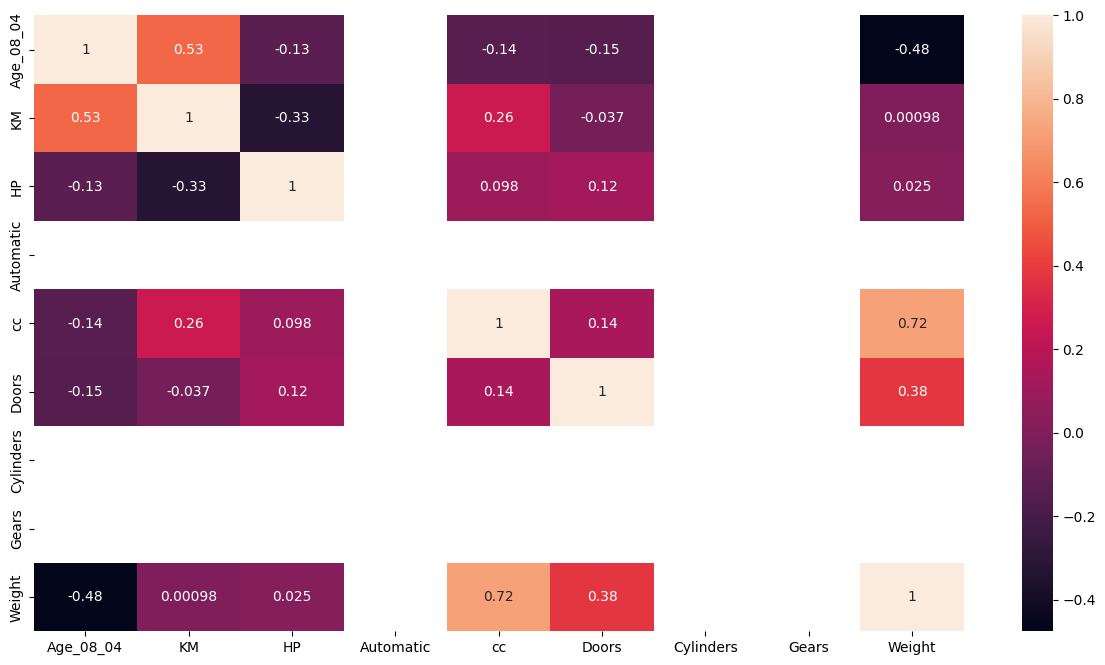

In [14]:
'''
Since columns "Weight" and "CC" are influencing for multiple features to be correlated, and also keeping in mind the fact that "Weight" is occasionally considered while looking for a car. We will drop the columns
'''

features.drop(columns=["Fuel_Type_CNG", "Fuel_Type_Petrol", "Fuel_Type_Diesel"], inplace=True)
corr = features.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr,annot=True)
plt.show()

[5790.99779388  840.16585167   99.18282444    0.           24.38471355
   49.65793735    0.            0.          497.96639064]


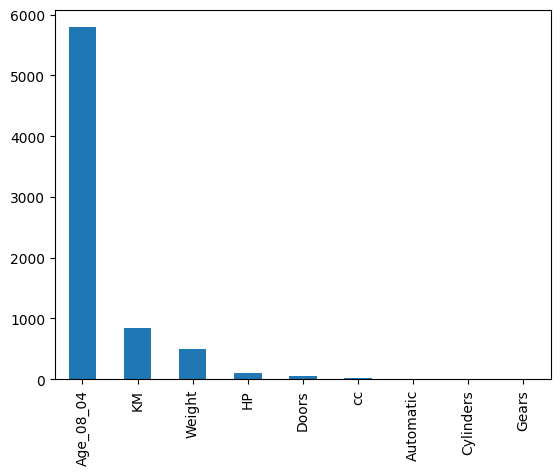

In [15]:
# 5. Feature Selection
f_reg= f_regression(features,target)
print(f_reg[0])
pd.Series(f_reg[0],index=features.columns).sort_values(ascending=False).plot(kind='bar')
plt.show()

In [16]:
features.drop(columns=["Automatic", "Cylinders", "Gears"], inplace=True)
corrdf = pd.DataFrame()
corrdf["Features"] = features.columns
corrdf["Correlation"] = f_regression(features,target)[0]
print(corrdf.sort_values(ascending=False, by="Correlation"))


    Features  Correlation
0  Age_08_04  5790.997794
1         KM   840.165852
5     Weight   497.966391
2         HP    99.182824
4      Doors    49.657937
3         cc    24.384714


In [17]:
features.head()

,Age_08_04,KM,HP,cc,Doors,Weight
0,23.0,46986.0,90.0,1900.0,3,1152.5
1,23.0,72937.0,90.0,1900.0,3,1152.5
2,24.0,41711.0,90.0,1900.0,3,1152.5
3,26.0,48000.0,90.0,1900.0,3,1152.5
4,30.0,38500.0,90.0,1900.0,3,1152.5


In [18]:
# 6. Splitting the dataset
x_train,x_test,y_train,y_test=train_test_split(features,target,train_size=0.8,random_state=100)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1148, 6)
(287, 6)
(1148,)
(287,)


In [19]:
# 7. Scaling
std_sca= StandardScaler()
x_train[["KM", "cc", "Weight"]] = std_sca.fit_transform(x_train[["KM", "cc", "Weight"]])
x_test[["KM", "cc", "Weight"]] = std_sca.transform(x_test[["KM", "cc", "Weight"]])
x_test.head()

,Age_08_04,KM,HP,cc,Doors,Weight
57,26.0,-0.710923,97.0,-0.910121,5,1.084718
1002,62.0,-0.826777,110.0,0.255237,5,0.173948
360,35.0,-1.260908,97.0,-0.910121,3,-1.127151
903,61.0,-0.247509,110.0,0.255237,5,0.043838
1276,79.0,0.189634,110.0,0.255237,5,0.173948


# 2. Visualization

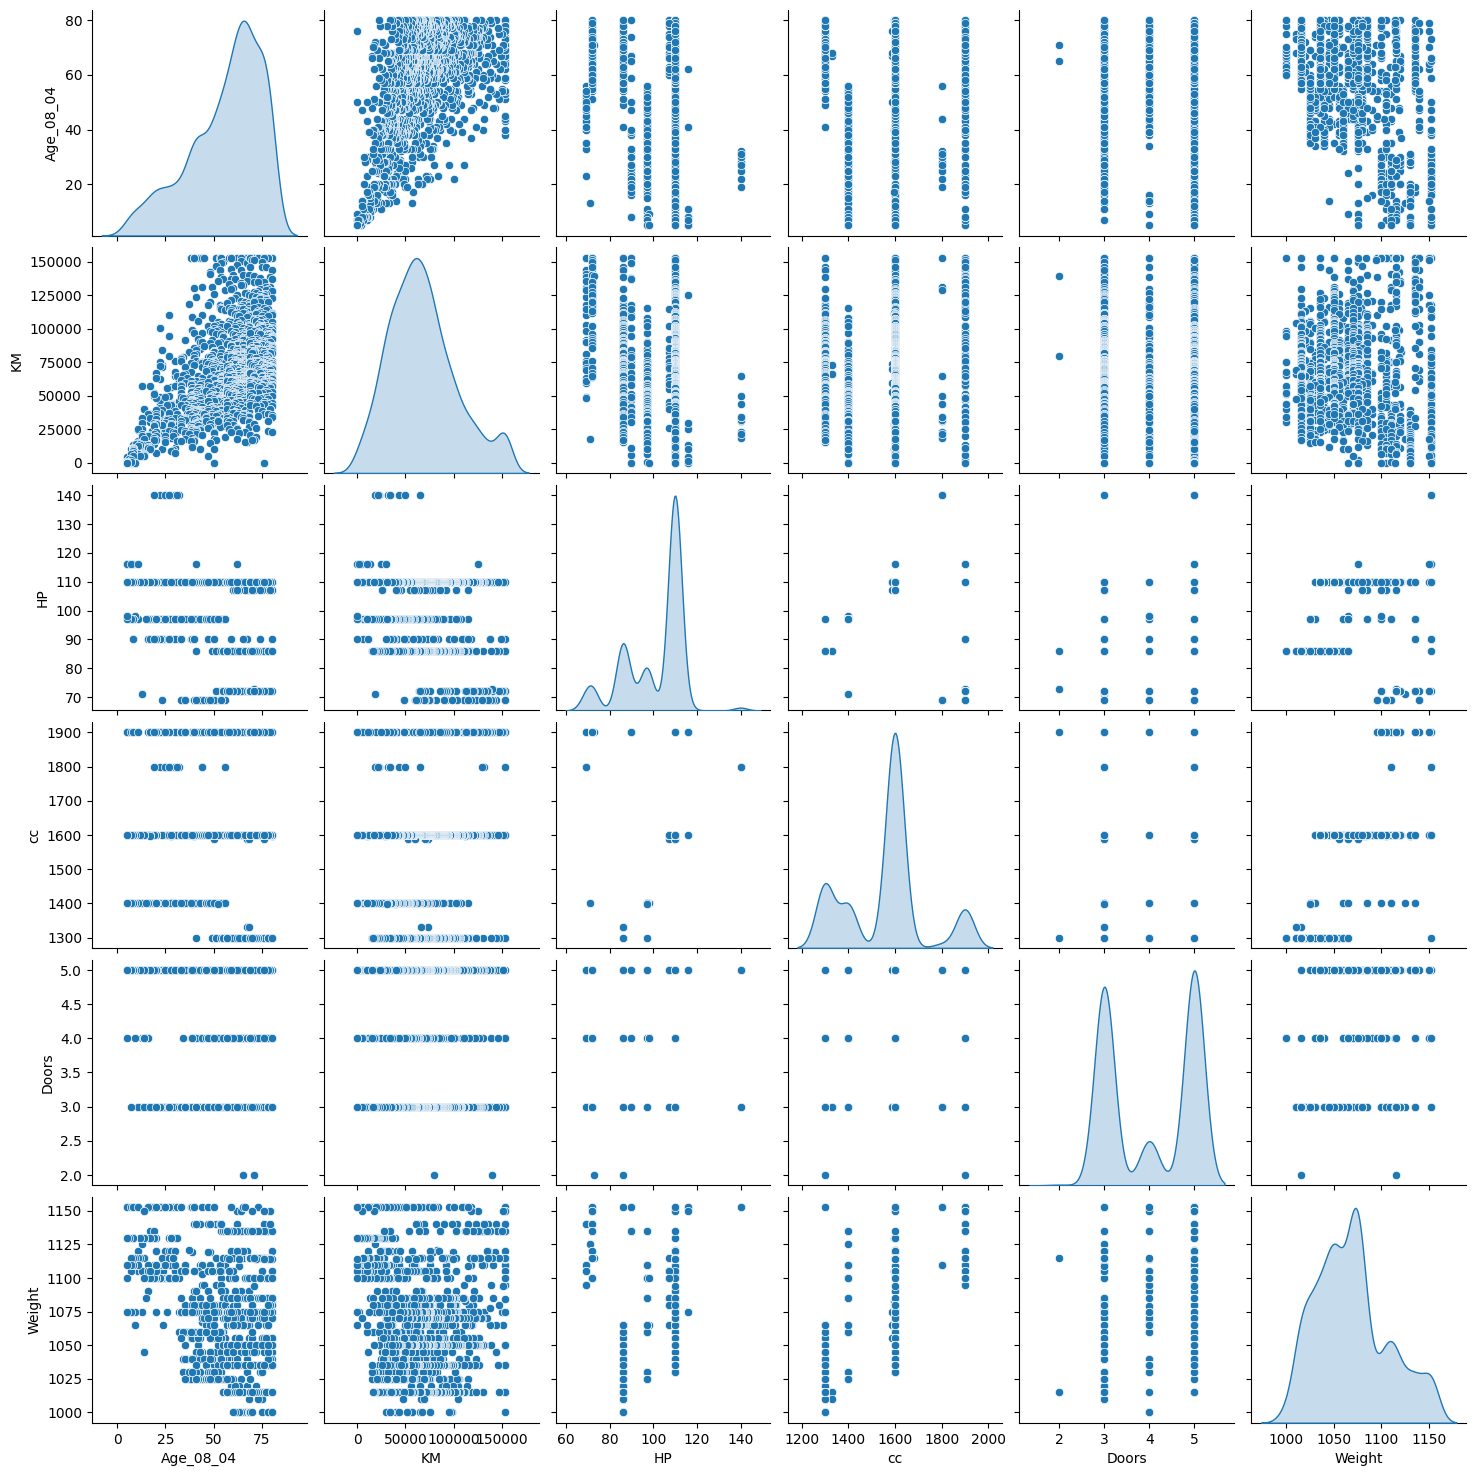

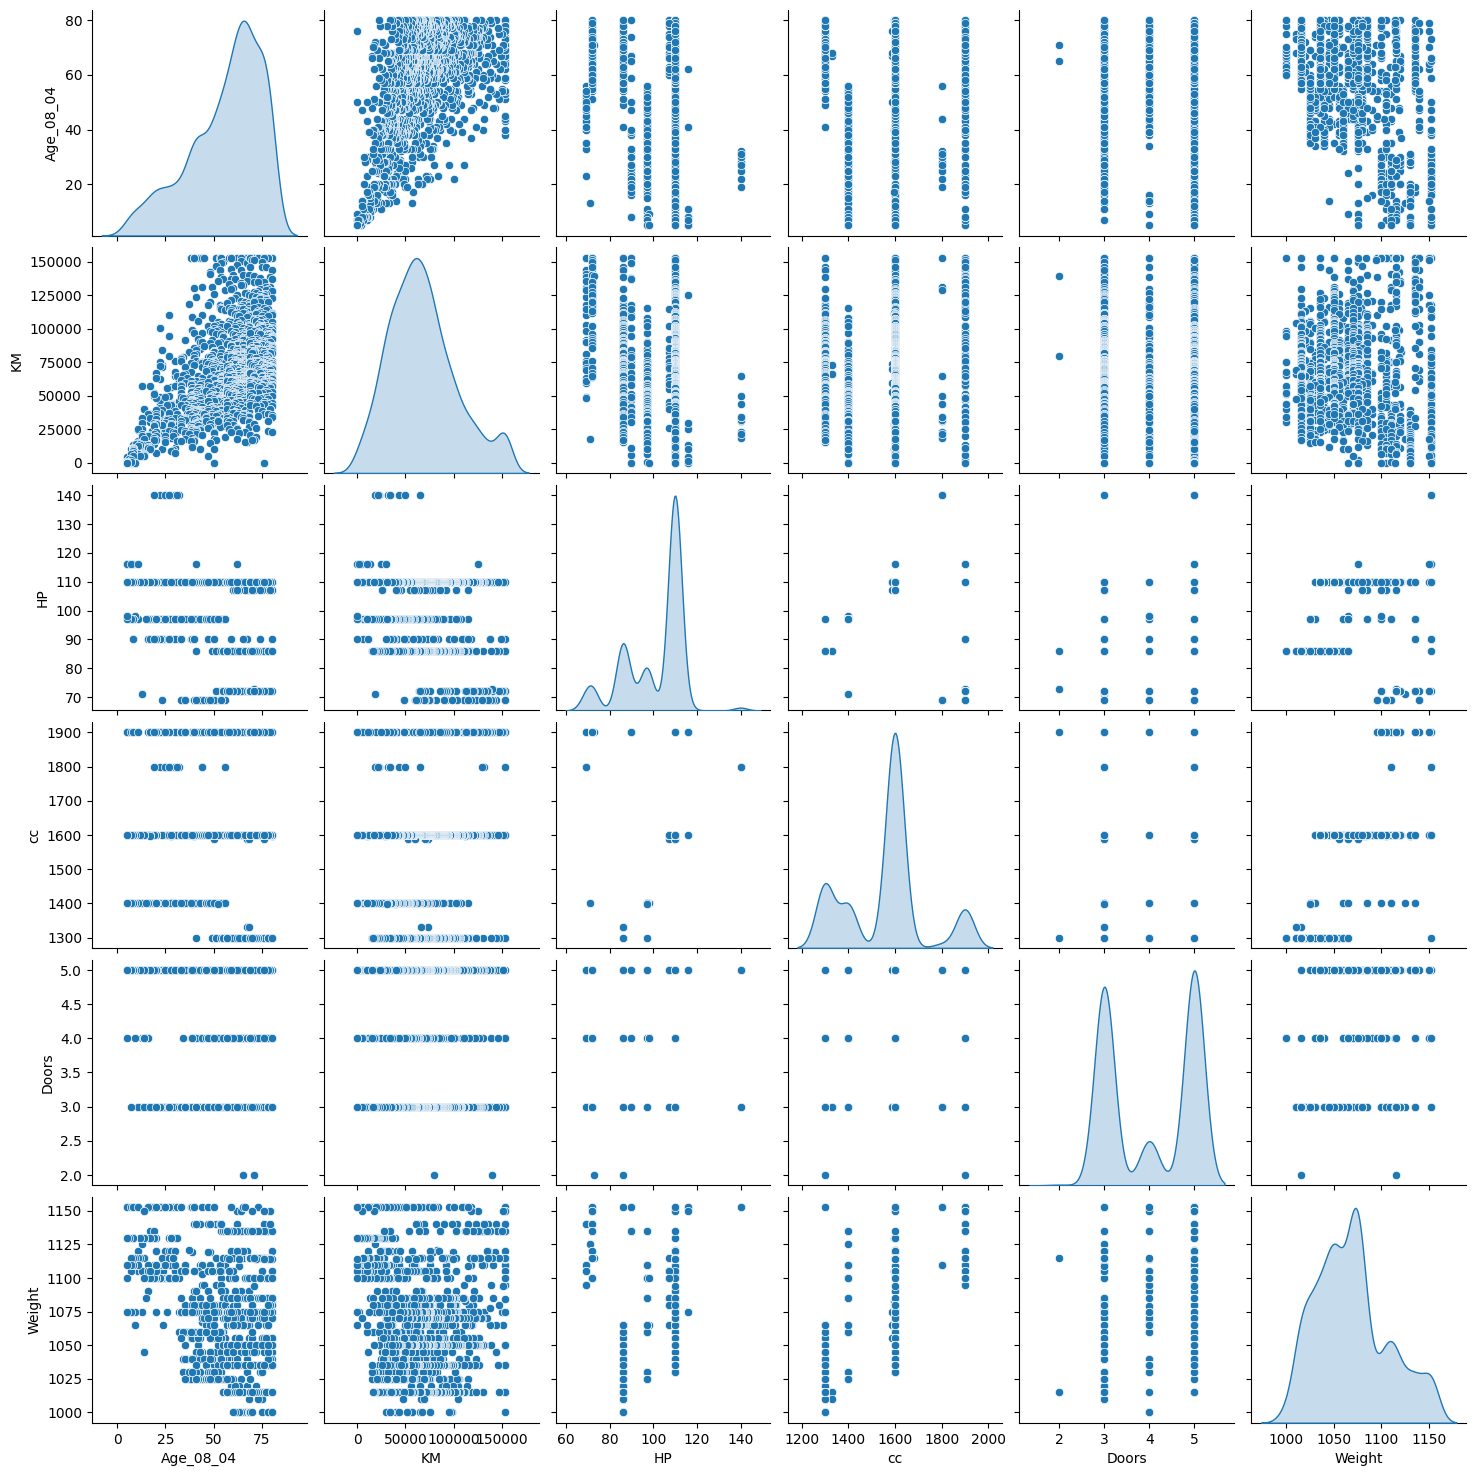

In [29]:
sns.pairplot(features, diag_kind="kde")
plt.show()

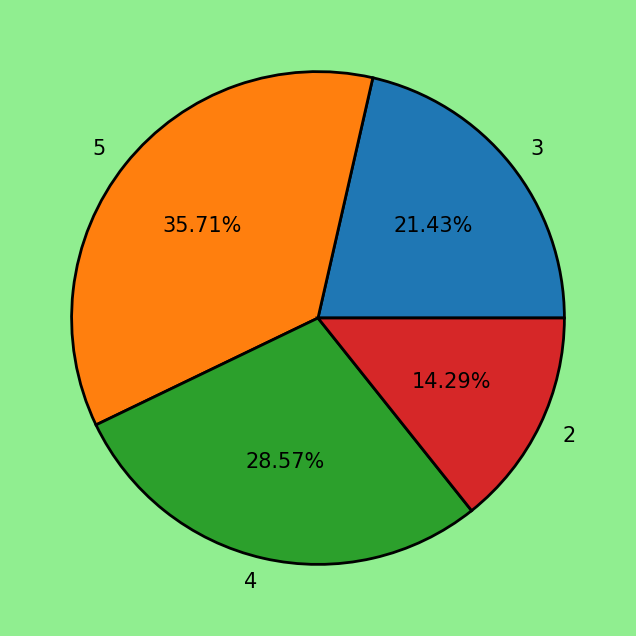

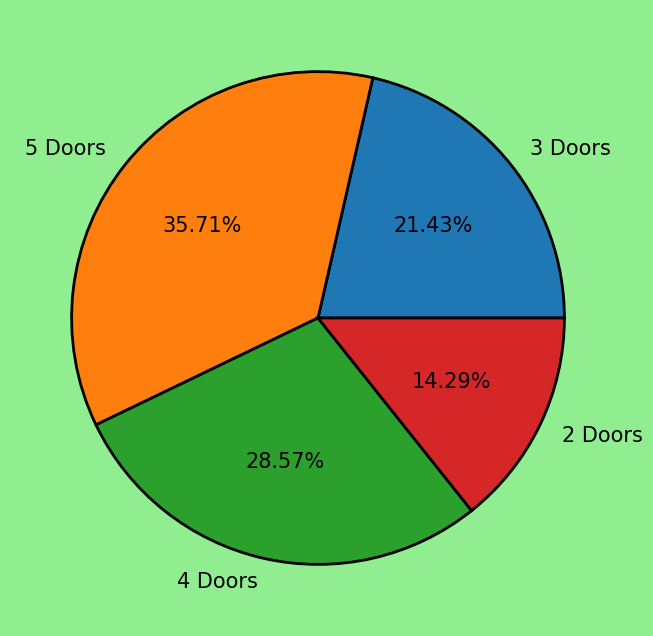

In [39]:
# Pie chart
types_of_doors = features["Doors"].unique()
plt.figure(figsize=(12,8), facecolor="lightgreen")
plt.pie(types_of_doors, labels=[f"{i} Doors" for i in types_of_doors], radius=1, autopct="%.2f%%", 
textprops={
    "color":"black",
    "size":15
},
wedgeprops={
    "linewidth":2,
    "edgecolor":"black"
})
plt.show()

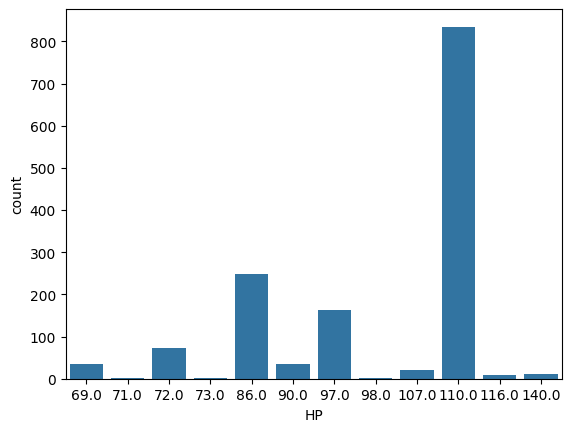

In [ ]:
sns.countplot(data=df,x="HP")
plt.show()

'''
The HP 110 seems to be more common for the Vehicles 
'''

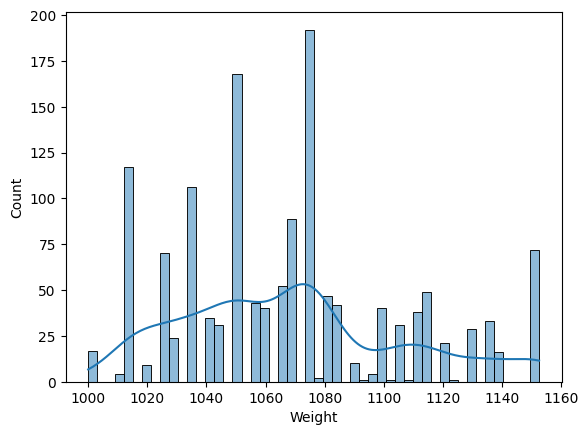

1068.520905923345


'\nWe can see the weight is mostly concentrated around the range 1060-1080\n'

In [ ]:
sns.histplot(data=df, x="Weight", bins=50, kde=True)
plt.show()

'''
We can see the weight is mostly concentrated around the range 1060-1080, the mean is also in that range 1068.00
'''

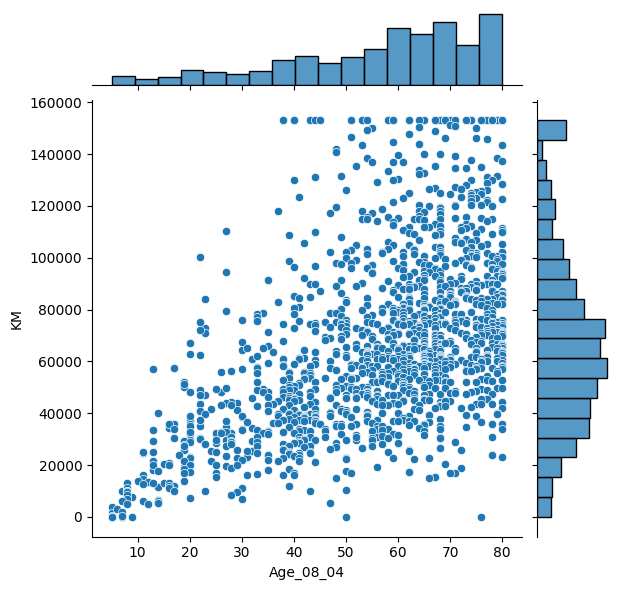

In [ ]:
sns.jointplot(data=df, x="Age_08_04",y="KM")
plt.show()

'''
We can observer a somewhat clear indication of a Positive correlation between the columns "Age_08_04" and "KM"
'''

# 3. Multiple Logistic Regression 

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [21]:
print("Coefficient = ", lin_reg.coef_)
print("Intercept = ", lin_reg.intercept_)

Coefficient =  [-105.29276276 -545.84661718   26.48103525 -421.70274935  -81.65641464
  946.39289947]
Intercept =  14046.70847479688


In [22]:
y_pred_train = lin_reg.predict(x_train)
r2_score(y_train, y_pred_train)

0.8675985105652546

In [23]:
y_pred_test = lin_reg.predict(x_test)
r2_score(y_test, y_pred_test)

0.8473627877706413

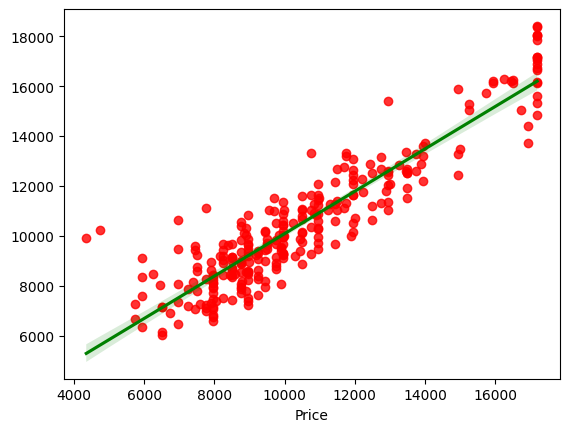

In [24]:
sns.regplot(x=y_test, y=y_pred_test, scatter_kws={"color":"red"}, line_kws={"color":"green"})
plt.show()

# 4. Lasso's Feature Selection

In [25]:
lassocv = LassoCV(alphas=100, max_iter=1000, cv=5)
lassocv.fit(x_train, y_train)
best_alpha = lassocv.alpha_
alphas = lassocv.alphas_

print(lassocv.coef_)
print(lassocv.intercept_)
print(best_alpha)

lasso = Lasso(alpha=best_alpha, max_iter=1000)
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
r2_score(y_test, y_pred)

[-112.95295899 -484.45633846   24.68412378 -187.19181154   -0.
  626.4852381 ]
14328.707614094192
49.81765549691024


0.8474796580699525

# 5. Ridge's Feature Apromixation

In [27]:
ridgecv = RidgeCV(alphas=(0.1,10,10.05), cv=5)
ridgecv.fit(x_train, y_train)
best_alpha = ridgecv.alpha_

print(ridgecv.coef_)
print(ridgecv.intercept_)
print(best_alpha)
print(ridgecv.alphas)


ridge = Ridge(alpha=best_alpha, max_iter=1000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
r2_score(y_test, y_pred)

[-105.30287497 -545.77343299   26.47909804 -421.42598183  -81.54949166
  945.97782256]
14047.040377561949
0.1
(0.1, 10, 10.05)


0.8473683447003015

# 6. Interview Questions

1. What is Normalization & Standardization and how is it helpful?

Normalization (Min–Max Scaling):
Normalization rescales numerical features to a fixed range, usually [0-1].
It preserves the relative relationships between values but changes their scale.
This method is sensitive to outliers, since min and max values affect all points.

Standardization (Z-score Scaling):
Standardization transforms data to have a mean of 0 and a standard deviation of 1.
It centers the data and scales it based on variability rather than absolute range.
This method is less affected by outliers compared to normalization.
It works well for algorithms like Linear Regression, Logistic Regression, and SVMs.



2.What techniques can be used to address multicollinearity in multiple linear regression?

Multi-collinearity is when two features of a Dataset have high correlation. Usually if > 10 when measured with VIF ratio. When a Model is trained with features having severe correlation, it causes for the result to change heavily with minute changes in feature and also intensifies the risk of overfitting. 

Here are some measures that we can take to avoid Multicollinearity amongst features.

1) Check for the VIF scores of features and eliminate the features having VIF > 10.
2) Perform Lasso's Feature Selection for elimination less important features
3) Perform Ridge's Feature Approximation to diminish the not so important feature's impact on the target prediction.